This notebook is my attempt to compare the different ways of looking at concordance.

In [84]:
import pandas as pd
import numpy as np

from scipy.stats import fisher_exact, spearmanr

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [100]:
fqvals = '../../data/analysis_results/qvalues.mean.kruskal-wallis.case-control.sig.txt'

df = pd.read_csv(fqvals, sep='\t', index_col=0)

# Pick one representative study per disease. If multiple studies have significant genera, 
# pick the study with the largest sample size. If only one study has significant
# genera, pick that one. If no studies have significant genera, don't include that
# disease in this analysis
dis2study = {'cdi': 'cdi_schubert', 'ob': 'ob_goodrich', 
             'crc': 'crc_baxter', 'ibd': 'ibd_gevers', 
             'hiv': 'hiv_noguerajulian', 'nash': 'nash_zhu', 
             'liv': 'liv_zhang', 'par': 'par_scheperjans'}
#alldiseases = dis2study.keys()
alldiseases = list(set([i.split('_')[0] for i in df.columns]))

results = []

# Fisher exact test on intersection of genera

Fisher exact test on genera which are present in both studies

In [101]:
effdir = np.sign(df).replace(0, np.nan) # anything with zero effect is NaN

for dis1 in alldiseases:
    dis1_studies = [i for i in df.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in df.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    # pd.crosstab automatically drops NaNs
                    mat = pd.crosstab(effdir[study1], effdir[study2])
                    odds, p = fisher_exact(mat)
                    results.append([dis1, dis2, study1, study2, p, 'fisher_intersection'])

In [102]:
resultsdf = pd.DataFrame(data=results, 
                         columns=['dis1', 'dis2', 'study1', 'study2', 'p', 'method'])\
                .dropna(subset=['p'])

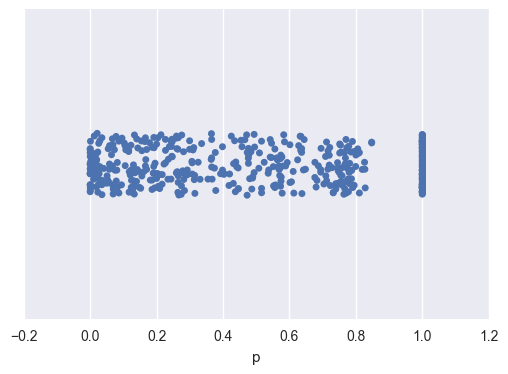

In [106]:
sns.stripplot(resultsdf['p'], jitter=True)

# Spearman correlation

Correlation between +1/-1 vectors, dropping any genera which are not present in both studies

In [87]:
for dis1 in alldiseases:
    dis1_studies = [i for i in df.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in df.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    # pd.crosstab automatically drops NaNs
                    r, p = spearmanr(effdir[study1], effdir[study2])
                    results.append([dis1, dis2, study1, study2, p, 'spearman', r])

In [88]:
from scipy.stats import kendalltau

for dis1 in alldiseases:
    dis1_studies = [i for i in df.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in df.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    # pd.crosstab automatically drops NaNs
                    r, p = kendalltau(effdir[study1], effdir[study2], nan_policy='omit')
                    results.append([dis1, dis2, study1, study2, p, 'kendalltau', r])

# Empirical - all genera

Empirically determine probability of finding that many concordant genera, and do consider all genera present in at least one of the studies. When building the null distribution, keep the NaN structure in place.

In [89]:
def shuffle_col(col):
    """
    Shuffles the index labels of one column after dropping NaN's.

    Calling df.apply(shuffle_col) shuffles each column values but preserves
    the location of NaN's.

    (Why does this work? Because this function returns a Series with only
    the non-NaN indices. When you call shuffle_col on an entire dataframe,
    I think pandas just fills in the missing indices with NaN's...)
    """
    newcol = pd.Series(
        data=col.dropna().values,
        index=np.random.permutation(col.dropna().index))
    return newcol

In [90]:
nreps = 500

effdir = np.sign(df).replace(0, np.nan) # Anything with zero effect should be NaN

dist = []
## Count number of actual concordant values
for dis1 in alldiseases:
    dis1_studies = [i for i in df.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in df.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    tmp = effdir[[study1, study2]].dropna(how='all')
                    n_concord = sum(tmp[study1] == tmp[study2])
                    dist.append(
                        [dis1, dis2, study1, study2,'observed', n_concord])

## Generate empirical null
for i in range(nreps):
    # Only shuffle entire dataframe once per rep
    shuffledeffdir = effdir.copy().apply(shuffle_col)
    
    for dis1 in alldiseases:
        dis1_studies = [i for i in df.columns if i.startswith(dis1)]
        for dis2 in alldiseases[alldiseases.index(dis1):]:
            dis2_studies = [i for i in df.columns if i.startswith(dis2)]

            for study1 in dis1_studies:
                for study2 in dis2_studies:
                    if study1 != study2:
                        tmp = shuffledeffdir[[study1, study2]].dropna(how='all')
                        n_concord = sum(tmp[study1] == tmp[study2])
                        dist.append(
                            [dis1, dis2, study1, study2,'expected', n_concord])

distdf = pd.DataFrame(data=dist,
                      columns=['dis1', 'dis2', 'study1', 'study2',
                               'metric', 'n_concord'])                        
## Calculate p values
pvals = []
for g, subdf in distdf.groupby(['study1','study2']):
    n_obs = subdf.query('metric == "observed"')['n_concord'].values
    n_exp = subdf.query('metric == "expected"')['n_concord'].values
    p = sum(n_exp >= n_obs)/float(len(n_exp))

    dis1 = subdf['dis1'].iloc[0]
    dis2 = subdf['dis2'].iloc[0]
    study1 = g[0]
    study2 = g[1]
    results.append([dis1, dis2, study1, study2, p, 'empirical_all', np.nan, n_obs[0], np.mean(n_exp)])


# Empirical concordance - only intersection of genera


In [91]:
nreps = 500

effdir = np.sign(df).replace(0, np.nan) # Anything with zero effect should be NaN

dist = []
## Count number of actual concordant values
for dis1 in alldiseases:
    dis1_studies = [i for i in df.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in df.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    tmp = effdir[[study1, study2]].dropna()
                    n_concord = sum(tmp[study1] == tmp[study2])
                    dist.append(
                        [dis1, dis2, study1, study2,'observed', n_concord])

## Generate empirical null
for i in range(nreps):
    # Only shuffle entire dataframe once per rep
    shuffledeffdir = effdir.copy().apply(shuffle_col)
    
    for dis1 in alldiseases:
        dis1_studies = [i for i in df.columns if i.startswith(dis1)]
        for dis2 in alldiseases[alldiseases.index(dis1):]:
            dis2_studies = [i for i in df.columns if i.startswith(dis2)]

            for study1 in dis1_studies:
                for study2 in dis2_studies:
                    if study1 != study2:
                        tmp = shuffledeffdir[[study1, study2]].dropna()
                        n_concord = sum(tmp[study1] == tmp[study2])
                        dist.append(
                            [dis1, dis2, study1, study2,'expected', n_concord])

distdf = pd.DataFrame(data=dist,
                      columns=['dis1', 'dis2', 'study1', 'study2',
                               'metric', 'n_concord'])                        
## Calculate p values
pvals = []
for g, subdf in distdf.groupby(['study1','study2']):
    n_obs = subdf.query('metric == "observed"')['n_concord'].values
    n_exp = subdf.query('metric == "expected"')['n_concord'].values
    p = sum(n_exp >= n_obs)/float(len(n_exp))

    dis1 = subdf['dis1'].iloc[0]
    dis2 = subdf['dis2'].iloc[0]
    study1 = g[0]
    study2 = g[1]
    results.append([dis1, dis2, study1, study2, p, 'empirical_intersect', np.nan, n_obs[0], np.mean(n_exp)])


In [92]:
resultsdf = pd.DataFrame(data=results, 
                         columns=['dis1', 'dis2', 'study1', 'study2', 'p', 'method', 'r', 'n_obs', 'mean_n_exp'])\
                .dropna(subset=['p'])

In [93]:
resultsdf.groupby('method')['p'].describe()

method                    
empirical_all        count     4.660000e+02
                     mean      4.365236e-01
                     std       3.226874e-01
                     min       0.000000e+00
                     25%       1.225000e-01
                     50%       4.190000e-01
                     75%       7.040000e-01
                     max       1.000000e+00
empirical_intersect  count     4.660000e+02
                     mean      4.341373e-01
                     std       3.213511e-01
                     min       0.000000e+00
                     25%       1.265000e-01
                     50%       4.210000e-01
                     75%       7.015000e-01
                     max       1.000000e+00
fisher_intersection  count     4.660000e+02
                     mean      4.958874e-01
                     std       3.505238e-01
                     min       3.612645e-15
                     25%       1.728428e-01
                     50%       4.843468e-01
     

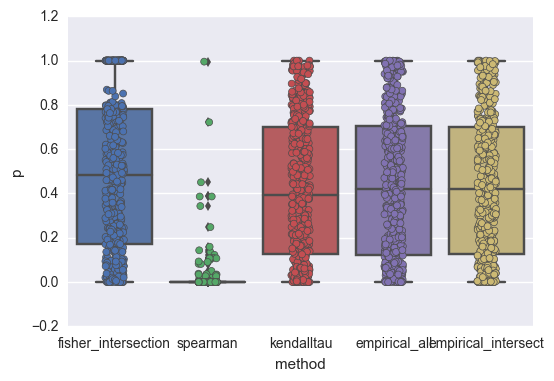

In [94]:
sns.boxplot(data=resultsdf, x='method', y='p')
sns.stripplot(data=resultsdf, x='method', y='p', jitter=True, linewidth=0.5)

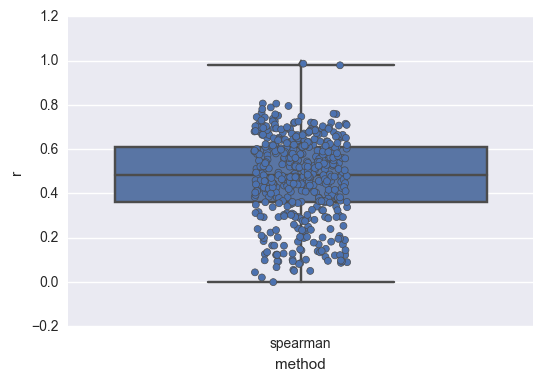

In [95]:
sns.boxplot(data=resultsdf.query('method == "spearman"'), x='method', y='r')
sns.stripplot(data=resultsdf.query('method == "spearman"'), x='method', y='r', jitter=True, linewidth=0.5)

In [96]:
sum(resultsdf.query('method == "spearman"')['p'] > 0.05)

21

In [97]:
resultsdf.query('method == "spearman"')['p'].shape

(466,)

In [98]:
resultsdf.query('method == "spearman"').sort_values(by='p', ascending=False).head(20)

,dis1,dis2,study1,study2,p,method,r,n_obs,mean_n_exp
883,ob,nash,ob_goodrich,nash_wong,0.995394,spearman,-0.000336,NaN,NaN
913,crc,nash,crc_zeller,nash_wong,0.721820,spearman,0.020709,NaN,NaN
853,ob,crc,ob_goodrich,crc_wang,0.450556,spearman,0.043870,NaN,NaN
889,crc,crc,crc_zeller,crc_wang,0.386370,spearman,0.050359,NaN,NaN
894,crc,crc,crc_wang,crc_zeller,0.386370,spearman,0.050359,NaN,NaN
855,ob,crc,ob_zupancic,crc_zeller,0.343310,spearman,0.055085,NaN,NaN
915,crc,nash,crc_baxter,nash_wong,0.248252,spearman,0.067091,NaN,NaN
865,ob,liv,ob_goodrich,liv_zhang,0.159452,spearman,0.081708,NaN,NaN
647,hiv,crc,hiv_noguerajulian,crc_zeller,0.143386,spearman,0.084970,NaN,NaN
510,t1d,crc,t1d_mejialeon,crc_zeller,0.135442,spearman,0.086688,NaN,NaN


In [99]:
resultsdf.to_csv('concordance_pvalues.different_methods.txt', sep='\t', index=False)

# One more question: empirical significance with different q thresholds?

What if we impose a q-value threshold (or perhaps effect size threshold?) from which to consider whether bugs are changing in the same direction?

In [107]:
fneffects = '../../data/analysis_results/qvalues.mean.kruskal-wallis.case-control.log2change.sig_ordered.txt'
effects = pd.read_csv(fneffects, sep='\t', index_col=0)
effects.head()

,cdi_youngster,hiv_noguerajulian,hiv_lozupone,t1d_alkanani,edd_singh,asd_son,crc_zeller,liv_zhang,ibd_papa,ob_zhu,...,crc_chen,ob_goodrich,hiv_dinh,noncdi_schubert,ibd_morgan,ob_zupancic,ob_turnbaugh,t1d_mejialeon,ibd_willing,nash_wong
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,10.356049,0.423552,0.662429,NaN,5.222960,NaN,1.271690,3.470789,10.356049,10.356049,...,1.532649,3.761708,4.114671,5.263545,NaN,NaN,NaN,0.753039,5.532374,0.203231
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium,NaN,NaN,5.871373,NaN,10.356049,NaN,NaN,NaN,NaN,10.356049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Lentisphaerae;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis,10.356049,0.885772,3.075544,NaN,-4.377625,0.069582,0.963358,NaN,NaN,NaN,...,NaN,-1.031472,NaN,-2.996785,NaN,NaN,NaN,10.356049,NaN,NaN
k__Bacteria;p__Lentisphaerae;c__Oligosphaeria;o__Oligosphaerales;f__Oligosphaeraceae;g__Oligosphaera,NaN,-1.825743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__Puniceicoccales;f__Puniceicoccaceae;g__Coraliomargarita,NaN,-1.346087,NaN,NaN,NaN,-0.420719,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Keep only things which have at least two-fold difference
twofold = lambda x: x if abs(x) >= 1 else np.nan
effects = effects.applymap(twofold)
effects.head()

,cdi_youngster,hiv_noguerajulian,hiv_lozupone,t1d_alkanani,edd_singh,asd_son,crc_zeller,liv_zhang,ibd_papa,ob_zhu,...,crc_chen,ob_goodrich,hiv_dinh,noncdi_schubert,ibd_morgan,ob_zupancic,ob_turnbaugh,t1d_mejialeon,ibd_willing,nash_wong
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,10.356049,NaN,NaN,NaN,5.222960,NaN,1.27169,3.470789,10.356049,10.356049,...,1.532649,3.761708,4.114671,5.263545,NaN,NaN,NaN,NaN,5.532374,NaN
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium,NaN,NaN,5.871373,NaN,10.356049,NaN,NaN,NaN,NaN,10.356049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Lentisphaerae;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis,10.356049,NaN,3.075544,NaN,-4.377625,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.031472,NaN,-2.996785,NaN,NaN,NaN,10.356049,NaN,NaN
k__Bacteria;p__Lentisphaerae;c__Oligosphaeria;o__Oligosphaerales;f__Oligosphaeraceae;g__Oligosphaera,NaN,-1.825743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__Puniceicoccales;f__Puniceicoccaceae;g__Coraliomargarita,NaN,-1.346087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
np.sign(effects).to_csv('log2_effect_sizes.greater_than_twofold.binary_values.txt', sep='\t')

### Empirical significant of effect directions, only looking at effects >= twofold difference

In [113]:
alldiseases = list(set([i.split('_')[0] for i in effects.columns]))

effresults = []

In [114]:
nreps = 500

effdir = np.sign(effects).replace(0, np.nan) # Anything with zero effect should be NaN

dist = []
## Count number of actual concordant values
for dis1 in alldiseases:
    dis1_studies = [i for i in effects.columns if i.startswith(dis1)]
    for dis2 in alldiseases[alldiseases.index(dis1):]:
        dis2_studies = [i for i in effects.columns if i.startswith(dis2)]

        for study1 in dis1_studies:
            for study2 in dis2_studies:
                if study1 != study2:
                    tmp = effdir[[study1, study2]].dropna()
                    n_concord = sum(tmp[study1] == tmp[study2])
                    dist.append(
                        [dis1, dis2, study1, study2,'observed', n_concord])

## Generate empirical null
for i in range(nreps):
    # Only shuffle entire dataframe once per rep
    shuffledeffdir = effdir.copy().apply(shuffle_col)
    
    for dis1 in alldiseases:
        dis1_studies = [i for i in effects.columns if i.startswith(dis1)]
        for dis2 in alldiseases[alldiseases.index(dis1):]:
            dis2_studies = [i for i in effects.columns if i.startswith(dis2)]

            for study1 in dis1_studies:
                for study2 in dis2_studies:
                    if study1 != study2:
                        tmp = shuffledeffdir[[study1, study2]].dropna()
                        n_concord = sum(tmp[study1] == tmp[study2])
                        dist.append(
                            [dis1, dis2, study1, study2,'expected', n_concord])

effdistdf = pd.DataFrame(data=dist,
                      columns=['dis1', 'dis2', 'study1', 'study2',
                               'metric', 'n_concord'])                        
## Calculate p values
pvals = []
for g, subdf in effdistdf.groupby(['study1','study2']):
    n_obs = subdf.query('metric == "observed"')['n_concord'].values
    n_exp = subdf.query('metric == "expected"')['n_concord'].values
    p = sum(n_exp >= n_obs)/float(len(n_exp))

    dis1 = subdf['dis1'].iloc[0]
    dis2 = subdf['dis2'].iloc[0]
    study1 = g[0]
    study2 = g[1]
    effresults.append([dis1, dis2, study1, study2, p, 'empirical', np.nan, n_obs[0], np.mean(n_exp)])


In [115]:
effdf = pd.DataFrame(data=effresults, 
                     columns=['dis1', 'dis2', 'study1', 'study2', 'p', 'method', 'r', 'n_obs', 'mean_n_exp'])

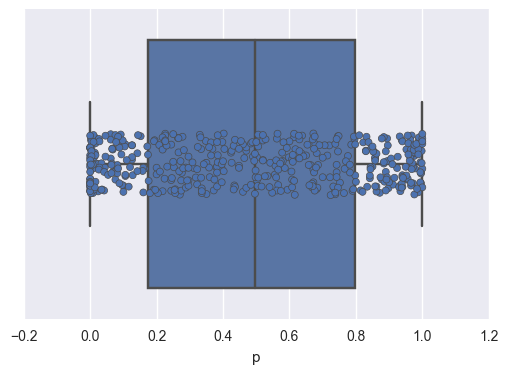

In [120]:
sns.boxplot(effdf['p'])
sns.stripplot(effdf['p'], jitter=True, linewidth=0.5)